In [ ]:
!pip install tensorflow==2.1

     |████████████████████████████████| 421.8 MB 25 kB/s 
     |████████████████████████████████| 3.8 MB 36.3 MB/s 
     |████████████████████████████████| 448 kB 40.5 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=62c87ddf1d011c7c4686b5cc11c9680e11ec01e3ee2da9a17eefba655bcf4dd4
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/cats_and_dogs_small

test  train  validation


In [ ]:
import os, shutil

In [ ]:
train_cats_dir= '/content/drive/MyDrive/cats_and_dogs_small/train/cats'
train_dogs_dir= '/content/drive/MyDrive/cats_and_dogs_small/train/dogs'

validation_cats_dir= '/content/drive/MyDrive/cats_and_dogs_small/validation/cats'
validation_dogs_dir= '/content/drive/MyDrive/cats_and_dogs_small/validation/dogs'

test_cats_dir= '/content/drive/MyDrive/cats_and_dogs_small/test/cats'
test_dogs_dir= '/content/drive/MyDrive/cats_and_dogs_small/test/dogs'

In [ ]:
train_dir= '/content/drive/MyDrive/cats_and_dogs_small/train'
test_dir= '/content/drive/MyDrive/cats_and_dogs_small/test'
validation_dir= '/content/drive/MyDrive/cats_and_dogs_small/validation'

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training cat images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training cat images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = os.path.join(train_dir)
validation_dir = os.path.join(validation_dir)
test_dir = os.path.join(test_dir)

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 575us/sample - loss: 0.5945 - acc: 0.6690 - val_loss: 0.4341 - val_acc: 0.8420
Epoch 2/30
2000/2000 [==============================] - 1s 358us/sample - loss: 0.4301 - acc: 0.8080 - val_loss: 0.3587 - val_acc: 0.8580
Epoch 3/30
2000/2000 [==============================] - 1s 353us/sample - loss: 0.3515 - acc: 0.8560 - val_loss: 0.3202 - val_acc: 0.8730
Epoch 4/30
2000/2000 [==============================] - 1s 364us/sample - loss: 0.3181 - acc: 0.8645 - val_loss: 0.3053 - val_acc: 0.8830
Epoch 5/30
2000/2000 [==============================] - 1s 363us/sample - loss: 0.2928 - acc: 0.8795 - val_loss: 0.2853 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 1s 362us/sample - loss: 0.2588 - acc: 0.9015 - val_loss: 0.2718 - val_acc: 0.8960
Epoch 7/30
2000/2000 [==============================] - 1s 367us/sample - loss: 0.2417 - acc: 0.9035 - val_loss: 0.2696 - va

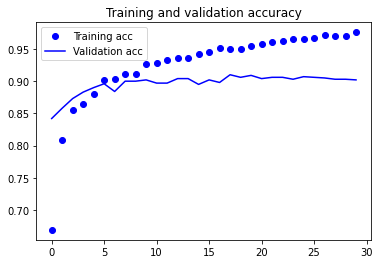

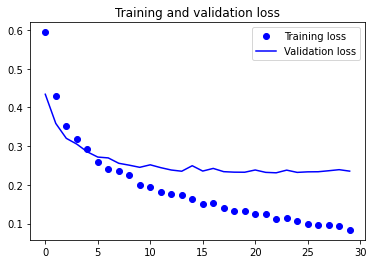

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [ ]:
conv_base.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 - 30s - loss: 0.5850 - acc: 0.7070 - val_loss: 0.4429 - val_acc: 0.8260
Epoch 2/30
100/100 - 29s - loss: 0.4829 - acc: 0.7805 - val_loss: 0.3654 - val_acc: 0.8710
Epoch 3/30
100/100 - 29s - loss: 0.4398 - acc: 0.8010 - val_loss: 0.3304 - val_acc: 0.8670
Epoch 4/30
100/100 - 29s - loss: 0.4089 - acc: 0.8185 - val_loss: 0.3068 - val_acc: 0.8780
Epoch 5/30
100/100 - 29s - loss: 0.3892 - acc: 0.8320 - val_loss: 0.3001 - val_acc: 0.8770
Epoch 6/30
100/100 - 29s - loss: 0.3696 - acc: 0.8410 - val_loss: 0.2815 - val_acc: 0.8850
Epoch 7/30
100/100 - 29s - loss: 0.3524 - acc: 0.8430 - val_loss: 0.2842 - val_acc: 0.8820
Epoch 8/30
100/100 - 29s - loss: 0.3512 - acc: 0.8390 - val_loss: 0.2663 - val_acc: 0.8910
Epoch 9/30
100/100 

In [ ]:
model.save('/content/drive/MyDrive/cats_and_dogs_small_3.h5')

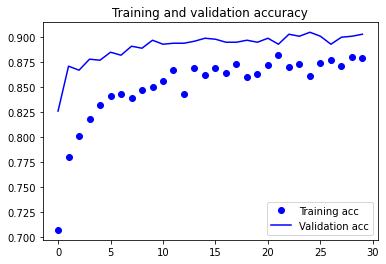

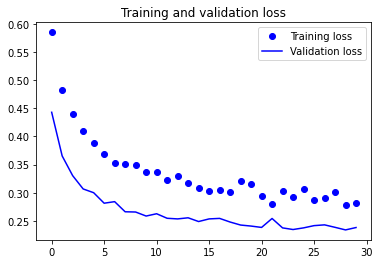

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 [==============================] - 32s 317ms/step - loss: 0.2907 - acc: 0.8720 - val_loss: 0.2147 - val_acc: 0.9130
Epoch 2/100
100/100 [==============================] - 31s 307ms/step - loss: 0.2703 - acc: 0.8780 - val_loss: 0.2133 - val_acc: 0.9150
Epoch 3/100
100/100 [==============================] - 30s 304ms/step - loss: 0.2443 - acc: 0.9035 - val_loss: 0.2074 - val_acc: 0.9150
Epoch 4/100
100/100 [==============================] - 31s 305ms/step - loss: 0.2354 - acc: 0.8995 - val_loss: 0.1907 - val_acc: 0.9260
Epoch 5/100
100/100 [==============================] - 30s 305ms/step - loss: 0.1950 - acc: 0.9205 - val_loss: 0.2691 - val_acc: 0.8980
Epoch 6/100
100/100 [==============================] - 31s 307ms/step - loss: 0.1992 - acc: 0.9180 - val_loss: 0.1871 - val_acc: 0.9310
Epoch 7/100
100/100 [==============================] - 30s 304ms/step - loss: 0.1820 - acc:

In [ ]:
model.save('/content/drive/MyDrive/cats_and_dogs_small_4.h5')

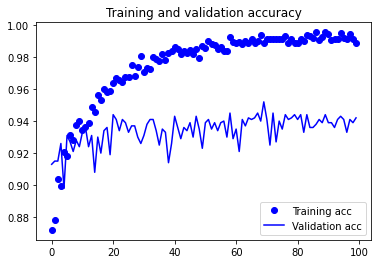

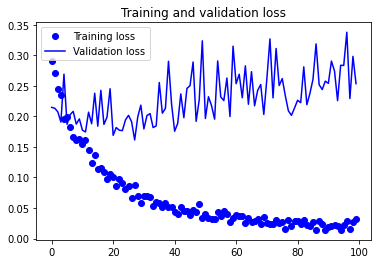

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

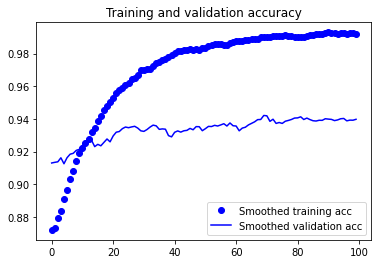

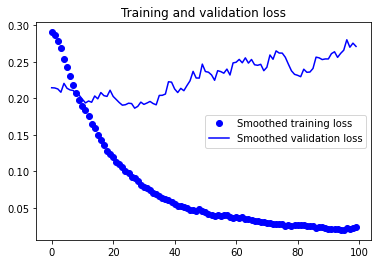

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
test acc: 0.939
